# Introduction

In this article, we discuss how to construct a Geometric Brownian Motion(GBM) simulation using Python. While building the script, we also explore the intuition behind GBM model. I will not be getting into theoretical background of its derivation. It's beyond the scope of this article. I care more about giving a high level understanding of what GBM needs as parameters, what its components are and how it creates predictions. I will try to have a bottom-up approach and build up the logic of GBM starting from its components. The simulation model we develop here is a discrete time model. Therefore, all mathematics discussed here is discrete time analogy of Geometric Brownian Motion for continuous stochastic processes. At the end of this article, we learn how to create simulations using GBM and you will have a full code for GBM simulation.    

# Content

1. What GBM does?
2. What input parameters do we need for GBM simulation?
3. The components of GBM: Drift and Diffusion
4. Building the discrete time GBM model
5. Making predictions in Python    

## 1. What GBM does?

I use E.ON's stock prices as an example throughout the article when explaining the related concepts. E.ON is an electric utility company based in Germany and it is one of the biggest in Europe. I retrieve its stock prices(in Euros) from Xetra Exchange through Python package of Quandl. Here is a link where you can display the stock prices: https://www.investing.com/equities/e.on-chart?cid=23453. In order to be able to use Quandl, you need to sign up and get an authorization token from its website and also you need to install quandl Python package. Assuming that you completed these steps, you can just use the code below to extract stock price data.  

Geometric Brownian Motion is widely used to model stock prices in finance and there is a reason why people choose it. In the line plot below, x axis indicates the days between 1 Jan, 2019 - 31 Jul, 2019 and y axis indicates the stock price in Euros. I want you to focus only on major, longer duration trends in the plot, disregarding the small fluctutations. You would realize that the stock price follows a wavy path. It increases from January to April, then it decreases until mid-May, followed by another increase series until mid-June and finally decreasing until the end of July. Now, I want you to focus on the shorter-term fluctuations. Let's investigate July. You can say that the general trend is downward, but the stock price doesn't just fall in a smooth manner. During its journey to end of July, it goes up and down continuously which indicates that there is not an interpretable pattern in this movement.  

So, we have already identified two components of the stock price movement. In July,  

    1. E.ON's stock price tends to fall, and
    2. there are random shocks each day to the falling stock price that result in an irregular line plot.  
    
As a result, we need a suitable model that takes into account both types of movements in the stock price. This is where Geometric Brownian Motion comes into play. GBM has two components that do this job. One component incorporates the long-term trend while the other component apply random shocks. We will talk about these in later sections.    

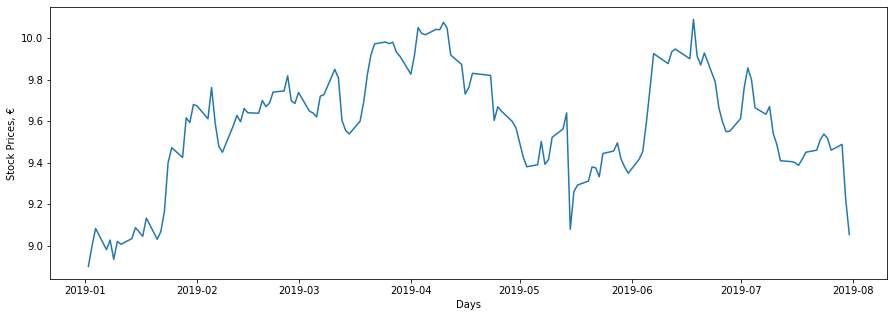

In [65]:
import pandas as pd
import numpy as np
import quandl
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Plot of E.ON(a big scale energy company in Europe) stock prices since beginning of 2019 (up to July)
prices = quandl.get("FSE/EON_X", authtoken="your_auth_token", 
                   start_date = '2019-01-01', end_date = '2019-07-31').reset_index(drop = False)[['Date', 'Close']]
plt.figure(figsize = (15, 5))
plt.plot(prices['Date'], prices['Close'])
plt.xlabel('Days')
plt.ylabel('Stock Prices, €')
plt.show()

## 2. What input parameters do we need for GBM simulation? 

Below are the input parameters that our GBM simulation model will take. We will discuss each of them one by one in detail. For the sake of this article, I will use E.ON's stock prices of July to make predictions for August. So, I want you to keep this in mind while reading about the input parameters.  

In [47]:
# Parameter Definitions

# So    :   initial stock price
# dt    :   time increment -> a day in our case
# T     :   length of the prediction time horizon(how many time points to predict, same unit with dt(days))
# N     :   number of time points in prediction the time horizon -> T/dt
# t     :   array for time points in the prediction time horizon [1, 2, 3, .. , N]
# mu    :   mean of historical daily returns
# sigma :   standard deviation of historical daily returns
# b     :   array for brownian increments
# W     :   array for brownian path

In [30]:
# We get daily closing stock prices of E.ON for July 2019
S_eon = quandl.get("FSE/EON_X", authtoken="your_auth_token", 
                   start_date = '2019-07-01', end_date = '2019-07-31').reset_index(drop = False)[['Date', 'Close']]
print(S_eon.head())
print(S_eon.tail())

        Date  Close
0 2019-07-01  9.612
1 2019-07-02  9.761
2 2019-07-03  9.856
3 2019-07-04  9.800
4 2019-07-05  9.664
         Date  Close
18 2019-07-25  9.517
19 2019-07-26  9.460
20 2019-07-29  9.488
21 2019-07-30  9.226
22 2019-07-31  9.054


### 1. So

This is the initial stock price. Forward stock price simulations take their roots from this initial stock price value. We will multiply this initial value with some expressions to get predictions for each of the days in August. In our case, So is the closing stock price in July 31, 2019.  

In [36]:
So = S_eon.loc[S_eon.shape[0] - 1, "Close"]
print(So)

9.054


### 2. dt

This is the time increment in our model. It means the time unit that we assume. Remember that we have the closing prices of E.ON stocks for each day, then the time increment in our model is 1 day. Please note that dt follows from the time steps in historical data. If the stock price data is published every 7.2 hours, then dt would be 0.3 since it corresponds to 7.2 hours = 0.3 days.  

In [37]:
dt = 1
print(dt)

1


### 3. T

T denotes the length of our prediction time horizon. We should be careful and consistent when specifying values for T and dt. For example, in our case, T should be 31 days since we want predictions for 31 days of August and when assigning a value to dt, following from our declaration of T, we should remember that dt must be represented in terms of days. The time unit for these two parameters has to be the same. Now, looking at a different example, suppose we have two stock price values for each day in our data and we know that we will make predictions for the 31 days in August. Under this setting, our time increment would be 0.5 days and we would assign 0.5 to dt. So, we would have 62 predictions after applying GBM, two predictions for each day in August.  
    
Remember the example in the previous part where we supposed stock price data is published every 7.2 hours. If we want our prediction time horizon to be 72 hours(T = 72), then the appropriate dt would be 7.2 hours itself, without needing to convert it to 0.3 days. So, at the end, we would have 72 / 7.2 = 10 predictions with 7.2 hours between each of them.
    
If you follow this idea when building and using a GBM model, it becomes a lot easier to use your model for different equities under different settings. This feels confusing to many people and that's why I try to standardize it like this here :) The ultimate point we are trying to reach is calculating N(explained in the next part) correctly. It is the number of time steps within our prediction horizon which is consistent with our historical data in terms of time increment magnitude. I know it's a simple thing, but building a line of reasoning is always a good idea to prevent potential confusions in different applications of our code in the future.  

In [38]:
T = 31
print(T)

31


### 4. N

This parameter comes automatically after assignment of dt and T. It is the number of time points in the prediction time horizon. In our case, our time increment is 1 day and we will get predictions for 31 days. This means, we have 31 different time points(days) and we will have 31 predictions at the end.  

In [39]:
N = T / dt
print(N)

31.0


### 5. t

This is an array where we show the time progression in our model. It is like a time ticker where we measure time through counting number of time points elapsed. Building array t follows from the calculation of N. Remember we have 31 time points(days) to make predictions for. That's why array t starts from 1 and goes up to 31. When we use an element from array t, it means, that much time point elapsed in the model. As our predictions get far away from the date of So(starting day), they will fluctuate more due to this array t with more time points getting elapsed. In our case, t would be the array below for our model.  
    
    Some other examples:  
    A. If dt is 0.5 days(two stock prices for each day) and T is 31 days, t would be [1 2 3 ... 62]  
    B. If dt is 7.2 hours and T is 72 hours, t would be [1 2 3 ... 10]  

In [49]:
t = np.arange(1, int(N) + 1)
print(t)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]


### 6. mu

This is the mean return of the stock prices within the historical date range selected. In our case, we pick days of July as the historical data and we should calculate mu using stock prices of July. Before calculating mu, we should calculate the return for each day. The calculation is below.  

![return.PNG](images/return.PNG)  

In [44]:
returns = (S_eon.loc[1:, 'Close'] - S_eon.shift(1).loc[1:, 'Close']) / S_eon.shift(1).loc[1:, 'Close']
print(returns.tolist())

[0.015501456512692377, 0.00973260936379476, -0.005681818181818097, -0.013877551020408265, -0.0032077814569537026, 0.00384096335513348, -0.013340227507755901, -0.005554973273241884, -0.008326306913996506, -0.0004251248804337693, -0.0005316321105793732, -0.0013829787234042447, 0.0030893789283050936, 0.0036108751062020944, 0.0010582010582012237, 0.0052854122621563355, 0.002944269190326022, -0.0022017194380374075, -0.0059892823368707165, 0.0029598308668074727, -0.0276138279932545, -0.018642965532191694]


![mu.PNG](images/mu.PNG)  

After calculating returns for all of the days in July, we need to calculate the arithmetic average using those returns to obtain mu. We will then use mu in our drift component calculation. It will have an effect on the long-term movement of the stock price. Also, as you can see below, mu is ~ -0.3 % which indicates that there is negative return on average during the month July and we should take into this account when calculating forward predictions for August.  

In [45]:
mu = np.mean(returns)
print(mu)

-0.0026705996693330543


One important thing to note is that we don't need to multiply mean return with a number for adjustment. We stay loyal to the time increment magnitude of our historical data and we create prediction series in the same way the historical data exists. To elaborate more, suppose, we are retrieving stock price data every 7.2 hours and we have the data for last 72 hours. Also, we want to make predictions for the following 36 hours. When we calculate mean return from the historical data, that mean return accounts for the associated time step length of 7.2 hours(There are 7.2 hours between two data points). When making predictions, following from our logic explained in above parts, we will have 5 time periods(36/7.2) with 7.2 hours between them. This means, we can use mean return as mu in our model without needing to adjust it according to time step length between our prediction time points.  

### 7. sigma

This is standard deviation of returns of the stock prices in July. Sigma is important, because, it will be helpful to incorporate random shocks to our predictions. Remember from the line plot of E.ON stock prices above, stock price continuously go up and down one day to another and magnitude or direction of this small movement seems to be random. Here, sigma will help us in determining the magnitude of the movement. Sigma, by itself, doesn't add the randomness we need to the model. We will use standard normal random variable when picking up random values. Sigma will contribute by scaling the magnitude of random shock so that the small fluctuations occur in accordance with the historical volatility of the stock prices. We don't want any irrelevant random values coming from standard normal distribution. Below, you can see how sigma is calculated.  

![sigma.PNG](images/sigma.PNG)  

In [46]:
sigma = np.std(returns)
print(sigma)

0.009362443851856311


Remember we said that we don't multiply mu with any number for adjustment, because we stay loyal to the length of time steps in the historical data when making predictions. The same exact logic applies here and we don't need to adjust sigma either.  

### 8. b

This array is the array where we add randomness to our model. Important thing here is the "scen_size" variable. Since this is a simulation model, we want to have many hypothetical paths for the stock price within prediction time horizon. Assigning 2 to "scen_size" means, at the end we will have 2 different stock price series. The logic for each scenario is the same with the other. So, I will discuss as if we are creating only 1 prediction series. Remember from the discussion of t, we declared an array for time progression which counts elapsed time points. Here array b, for each corresponding prediction time point, stores a random number coming from standard normal distribution. These random numbers will add the random shocks, that we have been talking since beginning of the article, to the model. That's why we will use numpy.random.normal() to generate random values from standard normal distribution. Again, we don't multiply this random value with any number for adjustment, following the same reasoning with mu and sigma.  

![b_arr.PNG](images/b_arr.PNG)  

In the example above, we assume our historical stock price data is daily and that's why we assign 1 to dt. Also, We want predictions for 5 days, which means the value of T is 5. Following these, N is calculated as 5 time points(5 1-day periods). So, for each of these time points, we generated a random number coming from standard normal distribution(mean=0, sigma=1) using numpy.random.normal() method. These random values composed our array b at the end. In our case, T should be 31 days. Below is the code where we create 2 arrays of random values with length 31 for 2 different scenarios.  

In [53]:
scen_size = 2
b = {str(scen): np.random.normal(0, 1, int(N)) for scen in range(1, scen_size + 1)}
print(b)

{'1': array([ 1.61023477,  0.87180974, -1.30308208,  0.32990059, -1.08701563,
        0.33015446, -0.85374392,  0.22344266,  0.92504497,  0.31628139,
       -0.61033903, -0.92931486, -0.35321309,  0.47300656,  1.57628643,
        0.07793848,  1.24680147,  0.36193452, -0.40005711, -0.19647728,
       -0.83457233, -0.24654118,  0.63800736,  0.01125661,  0.81640235,
       -0.07808541,  0.05072751,  0.55100638,  0.06241629,  2.2035579 ,
       -0.37734991]), '2': array([ 2.05980479, -1.04576881,  0.72122236,  0.9118059 , -0.45195932,
       -0.58017313,  0.42482732,  1.77097537,  0.68209221,  0.51191125,
       -0.332992  ,  0.38122476,  0.35331816,  0.48770657,  0.47373096,
        1.49027801,  0.02123952, -0.56518659,  1.70147752,  0.51452492,
        0.1950897 ,  1.64940956,  0.38466281, -1.6637891 ,  0.21796413,
       -0.11946471,  1.60712383,  0.70081562,  1.16420057, -0.62068068,
        0.90006612])}


### 9. W

W is the Brownian path and it determines how the stock prices fluctuate from beginning time point(So) to some other time point t. You should distinguish between b and W. In the next section, the difference between them will be a lot clearer, but still I want to mention briefly here. b is the random shock being applied to stock price at a time point when making a prediction for stock price of the NEXT time point. So, suppose, at time period 3, stock price is S_3. When making prediction for time period 4, b(4) is applied to S_3 as the random shock. W, on the other hand, is THE PATH. It means that it includes effects of all the random shocks since beginning of the prediction time horizon. It is the total effect of randomness incorporated into So(initial stock price) until the specific time point we are concerned with. So, suppose, we are making prediction for time period 4. We need to apply all the random shocks up-to and including time point 4 to So. Therefore, instead of b(4), we use W(4) which is the cumulative sum of array b elements with index less than or equal to 4. Below is the continuation of the example in the previous part where we discussed array b.  

![W_arr.PNG](images/W_arr.PNG)  

In [54]:
W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}
print(W)

{'1': array([ 1.61023477,  2.48204451,  1.17896243,  1.50886301,  0.42184738,
        0.75200184, -0.10174208,  0.12170057,  1.04674554,  1.36302693,
        0.75268789, -0.17662697, -0.52984006, -0.05683349,  1.51945294,
        1.59739142,  2.84419289,  3.20612741,  2.8060703 ,  2.60959302,
        1.77502069,  1.52847951,  2.16648687,  2.17774348,  2.99414583,
        2.91606042,  2.96678792,  3.5177943 ,  3.58021059,  5.78376849,
        5.40641859]), '2': array([ 2.05980479,  1.01403598,  1.73525834,  2.64706424,  2.19510492,
        1.61493179,  2.03975911,  3.81073448,  4.49282669,  5.00473794,
        4.67174594,  5.05297069,  5.40628886,  5.89399542,  6.36772639,
        7.85800439,  7.87924391,  7.31405732,  9.01553484,  9.53005975,
        9.72514946, 11.37455901, 11.75922182, 10.09543272, 10.31339685,
       10.19393214, 11.80105597, 12.50187159, 13.66607216, 13.04539148,
       13.9454576 ])}


Above is the code for our case. Following from array b calculation in the previous part, we take the cumulative sums according to W(k) expression above and create array W.  

This concludes our discussion of input parameters to GBM. We understood the reasoning behind each of them with examples and in the next sections, we will build GBM model from its components. It will make the input parameters in this section more meaningful to you.   

## 3. The components of GBM: Drift and Diffusion

Remember from Section 1, we already identified the two components of Geometric Brownian Motion. One is longer-term trend in the stock prices, and other one is the shorter-term random fluctuations. Now, we will give them names. We will call longer-term trends as Drift and we will call shorter-term fluctuations as Diffusion. In this section, I want you to suppose that we are at a specific time point (k-1) and we are going to make a prediction for time point (k). However, the same assumptions we talked in the previous section are still valid. Just as a reminder:  
    
    Assumption 1: length of time period between (k-1) and (k), which is dt, is in line with the historical data frequency.
    Assumption 2: the time in our simulation progresses through counting time periods.  
    
These assumptions make us ignore multiplying mu, sigma and z(k) with a time-length value for adjustment and we can form our array t as a time point counter [1 2 3 ...].    

Let's move on. We are at time point (k-1). Stock price at this time point needs to obey the longer-term trend in the stock prices while getting exposed to a random shock when we use it to create a prediction for time point (k). So, we need to apply the two components of GBM to this stock price.  

Let's see what these components are in mathematical terms:    

1. Drift:  

![drift.PNG](images/drift.PNG)  

Drift reflects the longer-term trend in the stock prices. As you can recall from the previous section, we already know mu and sigma. They are constant values calculated from the historical stock price data in July. So, our drift is a constant value and if we suppose there is no random shock, we can apply it to the stock price at time point (k-1) as you can see in above expression. If we keep applying the drift without any random shock, stock prices smoothly goes up if drift is positive or goes down if drift is negative. You should notice that the stock prices can never become 0 since drift is applied through the exponential function.  This is the story of drift. Now, let's move with the diffusion.  

2. Diffusion:  

![diffusion.PNG](images/diffusion.PNG)  

Diffusion reflects the shorter-term fluctuations. As you can recall from Section 2, array b stores the random shock information we need and it retrieves that random shock information from standard normal random variable z. When calculating the diffusion component, we multiply the random value z(k) with sigma. Here, you can notice how the randomness is incorporated into the GBM model. Also, the diffusion component makes it possible to create different stock price prediction scenarios. The drift component is constant. We can't create different scenarios out of it, but the diffusion component helps us create as many scenarios as we want since it involves Wiener process(It creates independent, stationary and normally distributed random shocks).  

So, when making prediction for time point (k) considering the stock price at time point (k-1), we need to add the effects of both of the components. The total combined effect gives us the prediction for time point (k). If there would only be the drift component, we would always know what the stock price will become in the next time point, but the diffusion component disturbs this smoothness by introducing random shock. So, we don't observe monotonous increase or decrease trend for the stock prices. Below is how the total combined effect is applied to the stock price at time point (k-1).  

![drf_diff.PNG](images/drf_diff.PNG)  

## 4. Building the discrete time GBM model

Up to now, we learnt why we need GBM, what the parameters of a discrete-time GBM model are and how to make a prediction for 1 time point ahead. Now, we build the generic closed form equation of the Geometric Brownian Motion adjusted for discrete-time context. In the previous section, we showed how to predict S(k) by multiplying S(k-1) with exp(drift + diffusion). As the continuation of this, we will try to predict S(k) using So(the initial stock price which is known).  

![s_ext.PNG](images/s_ext.PNG)  

To do that, we first replace S(k-1) with S(k-2)*exp(drift(k-1) + diffusion(k-1)).  
Then we replace S(k-2) with S(k-3)*exp(drift(k-2) + diffusion(k-2)).  
If we continue doing this, at the end we will have So multiplied by many exponential terms. You can see what we obtain at the end of this procedure below.  

![s_shrt.PNG](images/s_shrt.PNG)  

After that, we extend the equation above, expressing drift and diffusion terms separately this time.  

![s_diss.PNG](images/s_diss.PNG)  

Above is the penultimate equation for S(k).It means, we can predict S(k) from So by adding the combined effect of k many drifts and the cumulative diffusion up to k. From So to S(k), there are k many time points which we call as the path. Remember from the previous section, drift doesn't change from one time point to another. That's why, to predict k time points ahead, we just add the drift k many times. This is different for diffusion. In Section 2, when discussing W, we learnt that it is the Brownian path. You can recall that part. Based on that discussion, to predict k time points ahead, we should consider the the total effect of all the random shocks encountered on the path. In the last step of building the equation, we modify the equation just above by making below replacements.  

![w_t.PNG](images/w_t.PNG)  

Then, it gives us the final form of the equation with parameters that are all familiar to us and I hope all the discussions we made in Section 2 now help you to understand why we created those parameters in the way we did. 

We know So, we know mu, we know sigma, we know array t and we know array W. We can easily create predictions for all the time points in our prediction time horizon at a single step. We will do this in the next section.  

![s_fin.PNG](images/s_fin.PNG)  

## 5. Making predictions in Python

This is the last section of our article and it is the most fun part. We can now create the predictions. First thing to do is calculating the drift for all the time points in the prediction time horizon. You already remember array t. We just multiply it with drift and we get an array of drifts. This drift array contains the total drift for all the time points in the prediction time horizon.  

About diffusion, we will have diffusion array for each of the scenarios. Remember, we control how many scenarios we want using the "scen_size" variable. Now, for this problem we only have 2 scenarios. You can go up as much as you want. That's why you see 2 different diffusion arrays labeled with '1' and '2', respectively. But, it is the same logic for each of them. We multiply the Brownian(array W) path with sigma.  

In [55]:
drift = (mu - 0.5 * sigma**2) * t
print(drift)
diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, scen_size + 1)}
print(diffusion)

[-0.00271443 -0.00542885 -0.00814328 -0.01085771 -0.01357214 -0.01628656
 -0.01900099 -0.02171542 -0.02442985 -0.02714427 -0.0298587  -0.03257313
 -0.03528756 -0.03800198 -0.04071641 -0.04343084 -0.04614526 -0.04885969
 -0.05157412 -0.05428855 -0.05700297 -0.0597174  -0.06243183 -0.06514626
 -0.06786068 -0.07057511 -0.07328954 -0.07600397 -0.07871839 -0.08143282
 -0.08414725]
{'1': array([ 0.01507573,  0.023238  ,  0.01103797,  0.01412665,  0.00394952,
        0.00704058, -0.00095255,  0.00113941,  0.0098001 ,  0.01276126,
        0.007047  , -0.00165366, -0.0049606 , -0.0005321 ,  0.01422579,
        0.01495549,  0.0266286 ,  0.03001719,  0.02627168,  0.02443217,
        0.01661853,  0.0143103 ,  0.02028361,  0.020389  ,  0.02803252,
        0.02730145,  0.02777639,  0.03293515,  0.03351952,  0.05415021,
        0.05061729]), '2': array([0.01928481, 0.00949385, 0.01624626, 0.02478299, 0.02055155,
       0.01511971, 0.01909713, 0.03567779, 0.04206384, 0.04685658,
       0.04373896, 0.0

Below is the predictions. Since we have 2 scenarios, we will have two stock price prediction series as a result of the operation below. First line of code is just the final GBM equation we derived in the previous section. Second line just adds So to the prediction series, since it is the starting point and we may want to see it in our plots.  

In [56]:
S = np.array([So * np.exp(drift + diffusion[str(scen)]) for scen in range(1, scen_size + 1)]) 
S = np.hstack((np.array([[So] for scen in range(scen_size)]), S))
print(S)

[[9.054      9.16661385 9.21668839 9.08024647 9.08364537 8.96729468
  8.97067263 8.87513106 8.86960839 8.92250645 8.92470825 8.84980077
  8.74935393 8.69682917 8.71174892 8.81730292 8.79982028 8.87900925
  8.88499718 8.82778563 8.78767587 8.69564396 8.65207824 8.68032032
  8.65770256 8.70048253 8.67055662 8.65116069 8.67233293 8.65388001
  8.81032242 8.75545287]
 [9.054      9.20527812 9.09087942 9.12766239 9.18096143 9.11741261
  9.04344145 9.05487048 9.18130194 9.21507418 9.2342459  9.18054809
  9.18839868 9.19385356 9.21089357 9.2267578  9.33103496 9.30759155
  9.23337288 9.35620695 9.37590173 9.36758046 9.48757376 9.49599256
  9.323875   9.31759515 9.28195001 9.39712541 9.43334501 9.51087698
  9.43013652 9.4841593 ]]


As the last thing to do, we now create the plot of our predictions. As you can see below, we have 2 stock price prediction scenarios. One goes up and the other one goes down. The drift in our problem is negative as you can observe from the drift array. This means the longer-term trend is downward for the stock prices(Remember we are only considering July as the historical data. I am talking based on this!). However, in spite of a negative drift, we have a prediction that is going up. This is due to the random shocks. Remember, we create them using standard normal random variable. In the scenario where prices are going up, it is clear that these random shocks exceeded the drift effect and it resulted into such a series.  

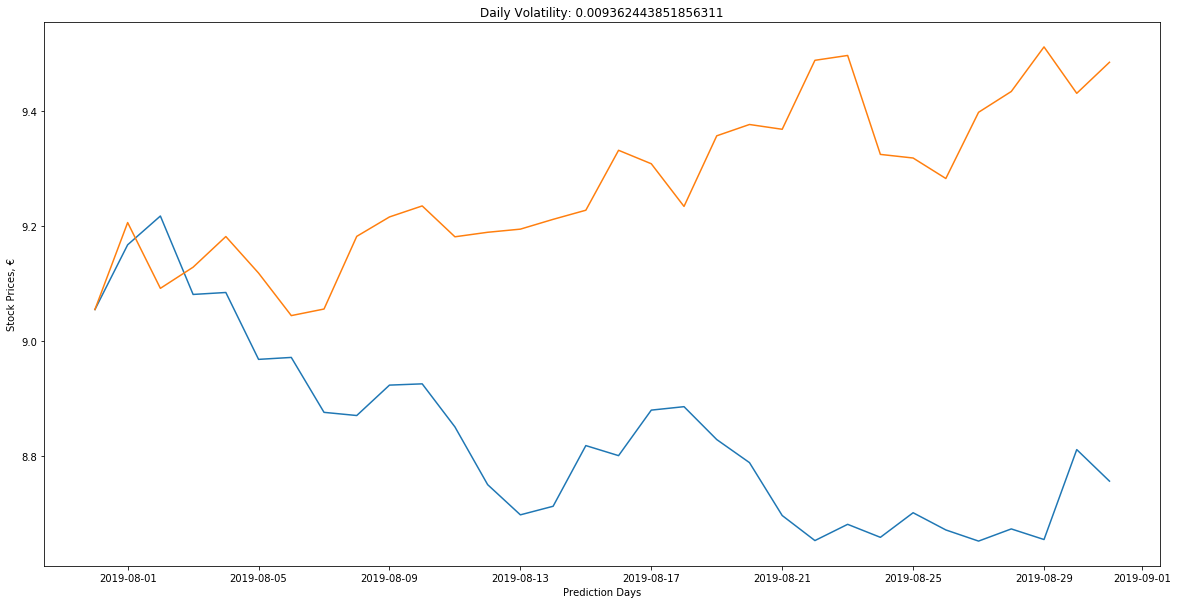

In [71]:
# Plotting the simulations
plt.figure(figsize = (20,10))
for i in range(scen_size):
    plt.title("Daily Volatility: " + str(sigma))
    plt.plot(pd.date_range(start = '2019-07-31', end = '2019-08-31', freq = 'D'), S[i, :])
    plt.ylabel('Stock Prices, €')
    plt.xlabel('Prediction Days')
    
plt.show()

# Conlusion

In this article, we learnt how to build a simulation model for stock prices using Geometric Brownian Motion in discrete-time context. Below is the full code. When you put your authorization token taken from Quandl after your registeration, you can use the code right away. In each run, you will get different stock price scenarios. It is because, we use np.random.normal() without setting seed. Each time we run the model, we will have a different array W and it will result into different predictions.  

Geometric Brownian Motion helps us to see what paths stock prices may follow and lets us to be prepared for what is coming. Of course, it is never possible to predict the exact future, but these statistical methods give us the chance of creating sound trading and hedging strategies that we can rely on.  

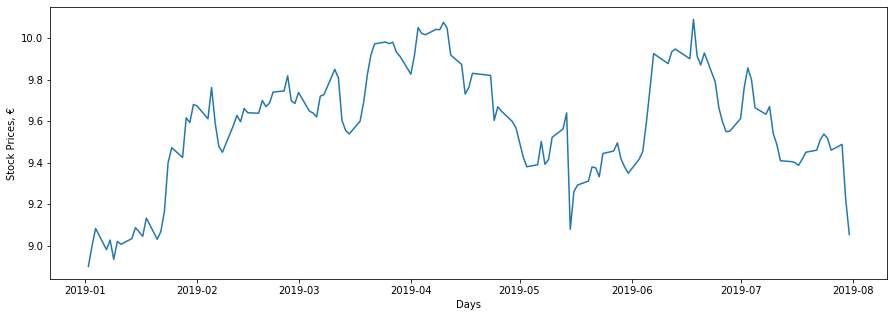

        Date  Close
0 2019-07-01  9.612
1 2019-07-02  9.761
2 2019-07-03  9.856
3 2019-07-04  9.800
4 2019-07-05  9.664
         Date  Close
18 2019-07-25  9.517
19 2019-07-26  9.460
20 2019-07-29  9.488
21 2019-07-30  9.226
22 2019-07-31  9.054
[0.015501456512692377, 0.00973260936379476, -0.005681818181818097, -0.013877551020408265, -0.0032077814569537026, 0.00384096335513348, -0.013340227507755901, -0.005554973273241884, -0.008326306913996506, -0.0004251248804337693, -0.0005316321105793732, -0.0013829787234042447, 0.0030893789283050936, 0.0036108751062020944, 0.0010582010582012237, 0.0052854122621563355, 0.002944269190326022, -0.0022017194380374075, -0.0059892823368707165, 0.0029598308668074727, -0.0276138279932545, -0.018642965532191694]
[-0.00271443 -0.00542885 -0.00814328 -0.01085771 -0.01357214 -0.01628656
 -0.01900099 -0.02171542 -0.02442985 -0.02714427 -0.0298587  -0.03257313
 -0.03528756 -0.03800198 -0.04071641 -0.04343084 -0.04614526 -0.04885969
 -0.05157412 -0.05428855 -0.05

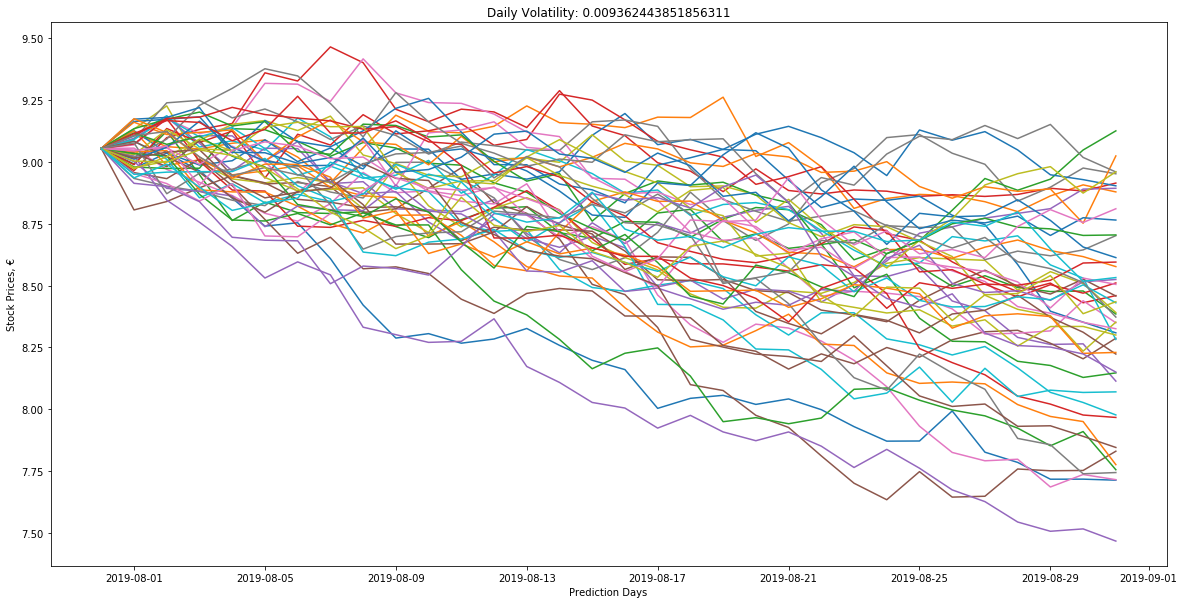

In [2]:
import pandas as pd
import numpy as np
import quandl
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

stock_name = 'FSE/EON_X'

# Plot of E.ON(a big scale energy company in Europe) stock prices since beginning of 2019 (up to July)
prices = quandl.get(stock_name, authtoken="py3UYy43X9dTYJb7X6es", 
                   start_date = '2019-01-01', end_date = '2019-07-31').reset_index(drop = False)[['Date', 'Close']]
plt.figure(figsize = (15, 5))
plt.plot(prices['Date'], prices['Close'])
plt.xlabel('Days')
plt.ylabel('Stock Prices, €')
plt.show()

#--------------------------------------------------- GEOMETRIC BROWNIAN MOTION ------------------------------------------------

# Parameter Definitions

# So    :   initial stock price
# dt    :   time increment -> a day in our case
# T     :   length of the prediction time horizon(how many time points to predict, same unit with dt(days))
# N     :   number of time points in prediction the time horizon -> T/dt
# t     :   array for time points in the prediction time horizon [1, 2, 3, .. , N]
# mu    :   mean of historical daily returns
# sigma :   standard deviation of historical daily returns
# b     :   array for brownian increments
# W     :   array for brownian path

start_date = '2019-07-01'
end_date = '2019-07-31'

# We get daily closing stock prices of E.ON for July 2019
S_eon = quandl.get(stock_name, authtoken="py3UYy43X9dTYJb7X6es", 
                   start_date = start_date, end_date = end_date).reset_index(drop = False)[['Date', 'Close']]
print(S_eon.head())
print(S_eon.tail())

returns = (S_eon.loc[1:, 'Close'] - S_eon.shift(1).loc[1:, 'Close']) / S_eon.shift(1).loc[1:, 'Close']
print(returns.tolist())

# Parameter Assignments
So = S_eon.loc[S_eon.shape[0] - 1, "Close"]
dt = 1 # day   # User input
T = 31 # days  # User input
N = T / dt
t = np.arange(1, int(N) + 1)
mu = np.mean(returns)
sigma = np.std(returns)
scen_size = 50 # User input
b = {str(scen): np.random.normal(0, 1, int(N)) for scen in range(1, scen_size + 1)}
W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}

# Calculating drift and diffusion components
drift = (mu - 0.5 * sigma**2) * t
print(drift)
diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, scen_size + 1)}
print(diffusion)

# Making the predictions
S = np.array([So * np.exp(drift + diffusion[str(scen)]) for scen in range(1, scen_size + 1)]) 
S = np.hstack((np.array([[So] for scen in range(scen_size)]), S)) # add So to the beginning series
print(S)

forward_end_date = (pd.to_datetime(end_date, format = "%Y-%m-%d") + pd.Timedelta(str(int(N)) + 'days')).strftime("%Y-%m-%d")
# Plotting the simulations
plt.figure(figsize = (20,10))
for i in range(scen_size):
    plt.title("Daily Volatility: " + str(sigma))
    plt.plot(pd.date_range(start = end_date, end = forward_end_date, freq = 'D'), S[i, :])
    plt.ylabel('Stock Prices, €')
    plt.xlabel('Prediction Days')
    
plt.show()